In this example we will build a matrix Lie map for a simple and well known Lotka-Volterra model. We also will compare simulation results with traditional numerical integration.

In [1]:
import numpy as np
import sympy as sp
from sympy import Symbol, expand

import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM
import sys
sys.path.insert(0,'..')

from core.Lie import LieLayer
from core.Lie_map_builder import LieMapBuilder

Using TensorFlow backend.


Let's define the saddle system

In [3]:
x = Symbol('x')
y = Symbol('y')
state = np.array([x,y])

p=0
q=-1
A = 0.5
B = 0.5

D = p-A
C = (A*D - q)/B

right_hand_side = [A*x+B*y, C*x+D*y]

order = 3
map_builder = LieMapBuilder(state, right_hand_side, order=order)
for P in map_builder.P:
    print P

[x y]
[0.5*x + 0.5*y, 1.5*x - 0.5*y]
[[0.]
 [0.]]
[[ 0.5  0.5]
 [ 1.5 -0.5]]
[[0. 0. 0.]
 [0. 0. 0.]]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]]


and build Lie:

In [4]:
R = map_builder.getInitR()
h = 0.001
N = 10
R = map_builder.propogate(h, N)

for Rk in R:
    print Rk

0 10
1 10
2 10
3 10
4 10
5 10
6 10
7 10
8 10
9 10
[[0.]
 [0.]]
[[1.00504925 0.00500008]
 [0.01500024 0.99504909]]
[[0. 0. 0.]
 [0. 0. 0.]]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]]


The map R now corresponds to dynamics of model in time period h*N. Then let's load this matrices into polynomial neural network:

In [5]:
W = map_builder.convert_weights_to_full_nn(R)
dim = len(state)

map = LieLayer(output_dim = dim, order = order, input_shape = (dim,))
model = Sequential()
model.add(map)
map.set_weights(W)

/usr/local/lib/python2.7/dist-packages/keras/engine/topology.py:622: UserWarning: Class `core.Lie.LieLayer` defines `get_output_shape_for` but does not override `compute_output_shape`. If this is a Keras 1 layer, please implement `compute_output_shape` to support Keras 2.
  output_shape = self.compute_output_shape(input_shape)


Now we can simply simulate our model via polynomial neural network prediction, as well as compare result with Runge-Kutta integration.

start simulation
elapsed time: 0.0993149280548 sec


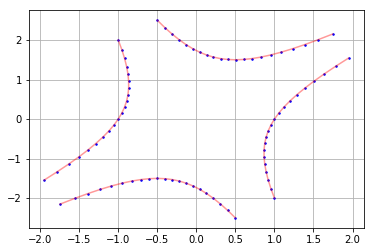

In [30]:
X0 = np.array([[-1, 2],
               [-0.5, 2.5],
               [0.5, -2.5],
               [1, -2],],
               dtype=float).reshape((-1, dim))
X = []
X.append(X0)
import time
print('start simulation')
start = time.time()
epoch_n = 200
for i in xrange(epoch_n):
    X.append(model.predict(X[-1])) 
print('elapsed time: %s sec'% (time.time()-start))

X = np.array(X)
plt.plot(X[::10,:,0], X[::10,:,1], 'b.', markersize=3)
plt.grid()
    
    
    
# compare to ode solver
from scipy.integrate import solve_ivp

def lv_system(t, state):
    x = state[0]
    y = state[1]
    return np.array([A*x+B*y, C*x+D*y])
    
t = h*N*epoch_n
for state0 in X0:
    X = solve_ivp(lv_system, [0, t], state0, max_step=0.1)
    plt.plot(X.y[0, :], X.y[1, :], 'r-', alpha = 0.4)
    
plt.show()